Image Embeddings Tutorial with Hugging Face
=================================================
  
[View on Google Colab](https://colab.research.google.com/drive/1AQPc0q6kN_ADS_Fbu-FIE_YrnQXb-G0o?usp=sharing)
  
In this notebook you will learn:  
1. Loading MNIST dataset from Hugging Face  
2. Creating embeddings using Vision Transformer  
3. Visualizing embeddings in 2D space  
4. Computing and displaying similarity matrices  

### Import the necessary libraries

In [1]:
! pip install torch transformers datasets pillow matplotlib seaborn librosa scikit-learn
! pip install "numpy<2.0.0"
! pip install --upgrade scikit-learn

import numpy as np
import torch
from transformers import AutoModel, AutoImageProcessor, AutoModelForImageClassification


from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from typing import List, Union, Optional

import warnings
warnings.filterwarnings('ignore')


  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 3.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 3.8 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 3.8 MB/s  0:00:02 eta 0:00:01
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

/Users/srishtigureja/Desktop/Personal/outskill/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


---

### Load the MNIST Dataset from HuggingFace

In [3]:
def load_mnist_dataset(num_samples: int = 1000) -> tuple:
    """
    Load MNIST dataset from Hugging Face datasets.
    
    Args:
        num_samples (int, optional): Number of samples to load from the dataset.
            Default is 1000 for faster processing.
    
    Returns:
        tuple: (images, labels) where images is a list of PIL Images and 
               labels is a list of corresponding digit labels.
    """
    print(f"Loading MNIST dataset from Hugging Face...")
    
    # Load the MNIST dataset from Hugging Face
    dataset = load_dataset("mnist", split="train")
    
    # Take a subset for demonstration
    dataset = dataset.select(range(min(num_samples, len(dataset))))
    
    # Extract images and labels
    images = dataset["image"]
    labels = dataset["label"]
    
    print(f"Loaded {len(images)} images with labels")
    print(f"Image format: {images[0].mode}, Size: {images[0].size}")
    
    return images, labels

In [4]:
# Step 1: Load MNIST dataset
print("\n1. Loading MNIST Dataset:")
print("-" * 30)

images, labels = load_mnist_dataset(num_samples=1000)


1. Loading MNIST Dataset:
------------------------------
Loading MNIST dataset from Hugging Face...


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 1154183.82 examples/s]

Loaded 1000 images with labels
Image format: L, Size: (28, 28)


---

### Visualize the Sample Images

In [11]:
def visualize_sample_images(images: List[Image.Image], labels: List[int], num_samples: int = 20):
    """
    Display a grid of sample images with their corresponding labels and embedding info.
    
    Args:
        images (List[Image.Image]): List of PIL images.
        labels (List[int]): List of corresponding labels.
        num_samples (int, optional): Number of sample images to display. Default is 20.
    """
    # Select random samples
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    # Create subplot grid
    cols = 5
    rows = (num_samples + cols - 1) // cols
    
    plt.figure(figsize=(15, 3 * rows))
    
    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        
        # Display the image
        plt.imshow(images[int(idx)], cmap='gray')
        plt.axis('off')
        
        # Add title with label 
        plt.title(f'Label: {labels[int(idx)]}', 
                 fontsize=10)
    
    plt.suptitle('Sample MNIST Images', fontsize=16)
    plt.tight_layout()
    plt.show()




2. Sample Images from Dataset:
-----------------------------------


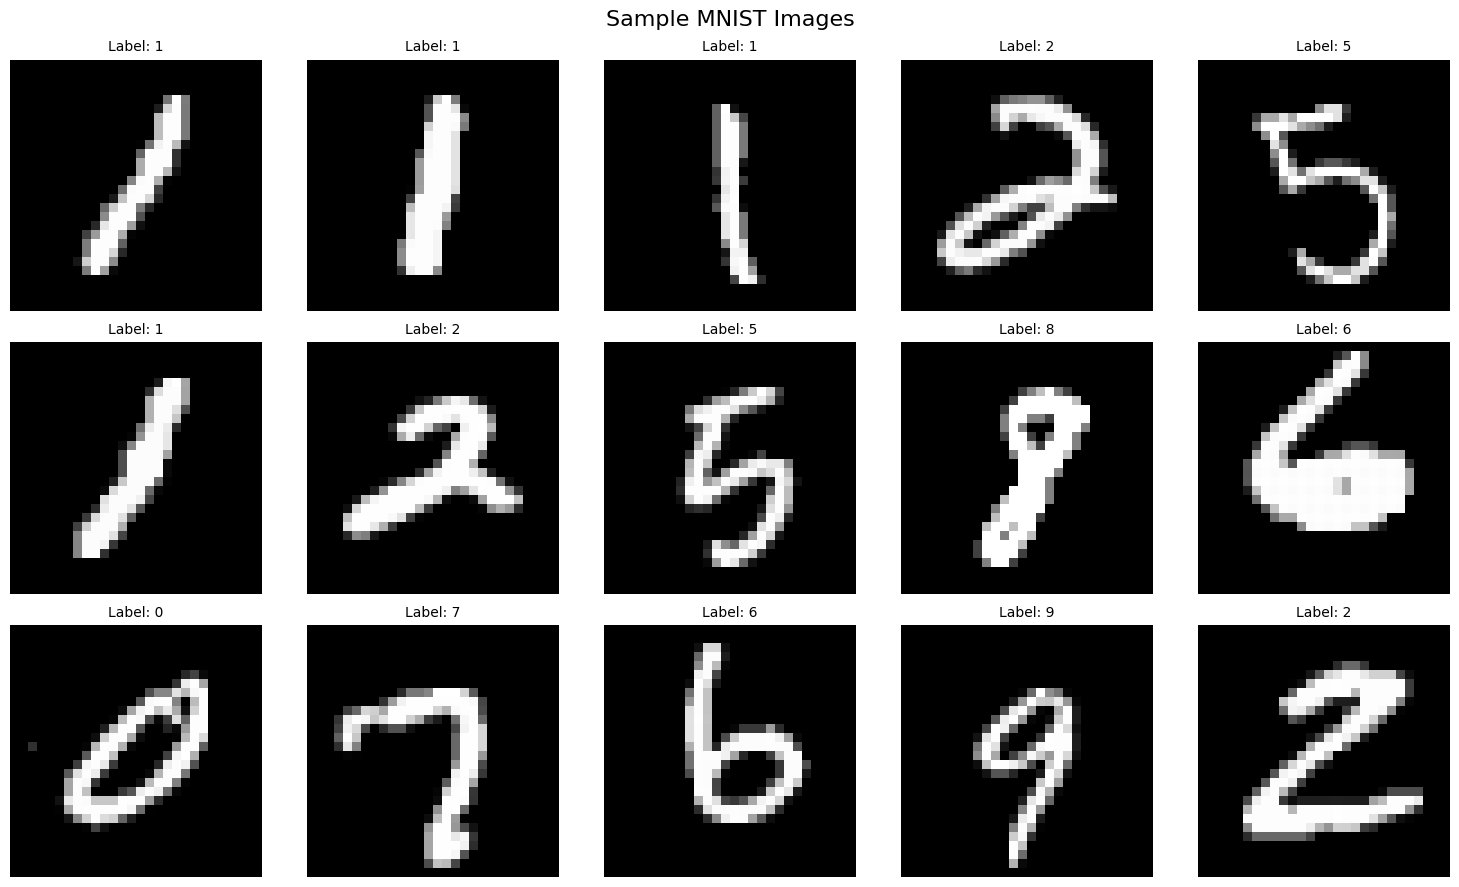

In [12]:
# Step 2: Display sample images
print("\n2. Sample Images from Dataset:")
print("-" * 35)

visualize_sample_images(images, labels, num_samples=15)

---

### Generate the Image Embeddings

In [13]:
def create_image_embeddings(
    images: Union[Image.Image, List[Image.Image]], 
    model_name: str = "google/vit-base-patch16-224",
    normalize: bool = True,
    device: Optional[str] = None
) -> np.ndarray:
    """
    Create dense vector embeddings for images using pre-trained vision transformer models.
    
    This function uses Hugging Face vision models to convert images into numerical
    representations that capture visual features. These embeddings can be used
    for image similarity search, clustering, classification, and retrieval tasks.
    
    Args:
        images (Union[Image.Image, List[Image.Image]]): Single PIL Image or list of 
            PIL Images to embed. Each image will be converted to a fixed-size vector.
        model_name (str, optional): Name of the pre-trained vision model from Hugging Face.
            Default is "google/vit-base-patch16-224" (Vision Transformer). Other options:
            - "microsoft/resnet-50" (ResNet-50 CNN architecture)
            - "facebook/deit-base-distilled-patch16-224" (Distilled Vision Transformer)
            - "microsoft/swin-base-patch4-window7-224" (Swin Transformer)
        normalize (bool, optional): Whether to normalize embeddings to unit vectors.
            Normalized embeddings work better for cosine similarity. Default is True.
        device (Optional[str], optional): Device to run the model on ('cpu', 'cuda').
            If None, automatically detects available device.
    
    Returns:
        np.ndarray: Array of embeddings with shape (n_images, embedding_dim).
            Each row represents the embedding vector for one input image.
    
    Example:
        >>> # Single image embedding
        >>> image = Image.open("path/to/image.jpg")
        >>> embedding = create_image_embeddings(image)
        >>> print(f"Embedding shape: {embedding.shape}")
        
        >>> # Multiple images
        >>> images = [image1, image2, image3]
        >>> embeddings = create_image_embeddings(images)
        >>> print(f"Embeddings shape: {embeddings.shape}")
    """
    
    # Step 1: Handle input format - convert single input to list
    if isinstance(images, Image.Image):
        images = [images]
        single_input = True
    else:
        single_input = False
    
    # Step 2: Determine compute device (GPU if available, else CPU)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(f"Using device: {device}")
    print(f"Loading vision model: {model_name}")
    
    # Step 3: Load pre-trained image processor and model
    # The image processor handles image preprocessing (resize, normalize, etc.)
    try:
        image_processor = AutoImageProcessor.from_pretrained(model_name)
        # Try to load as a feature extraction model first
        model = AutoModel.from_pretrained(model_name)
    except:
        # Fallback to classification model if feature extraction model not available
        print("Feature extraction model not available, using classification model...")
        from transformers import AutoFeatureExtractor
        try:
            image_processor = AutoFeatureExtractor.from_pretrained(model_name)
        except:
            image_processor = AutoImageProcessor.from_pretrained(model_name)
        model = AutoModelForImageClassification.from_pretrained(model_name)
    
    model.to(device)
    model.eval()  # Set to evaluation mode
    
    # Step 4: Convert MNIST grayscale images to RGB for compatibility
    print(f"Processing {len(images)} image(s)...")
    processed_images = []
    
    for i, image in enumerate(images):
        # Convert grayscale to RGB if needed (MNIST images are grayscale)
        if image.mode != 'RGB':
            # Convert grayscale to RGB by duplicating the single channel
            image = image.convert('RGB')
        processed_images.append(image)
    
    # Step 5: Apply image preprocessing (resize, normalize, tensor conversion)
    print("Applying image preprocessing...")
    inputs = image_processor(processed_images, return_tensors="pt")
    
    # Move processed inputs to the same device as the model
    pixel_values = inputs['pixel_values'].to(device)
    
    # Step 6: Generate embeddings using the vision model
    print("Generating image embeddings...")
    with torch.no_grad():  # Disable gradient computation for efficiency
        # Forward pass through the vision model
        outputs = model(pixel_values=pixel_values)
        
        # Extract embeddings based on model architecture
        if hasattr(outputs, 'last_hidden_state'):
            # For models like ViT that return sequence outputs
            # Use the [CLS] token embedding (first token) for image representation
            embeddings = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)
        elif hasattr(outputs, 'pooler_output'):
            # For models with pooler output
            embeddings = outputs.pooler_output
        elif hasattr(outputs, 'logits'):
            # For classification models, extract features before final layer
            # We need to access the hidden features, not the classification logits
            if hasattr(model, 'vit'):
                # For ViT models wrapped in classification head
                embeddings = model.vit(pixel_values=pixel_values).last_hidden_state[:, 0, :]
            elif hasattr(model, 'resnet'):
                # For ResNet models
                embeddings = model.resnet(pixel_values=pixel_values).pooler_output
            else:
                # Fallback: use logits as embeddings (not ideal but functional)
                print("Warning: Using classification logits as embeddings")
                embeddings = outputs.logits
        else:
            raise ValueError("Could not extract embeddings from model outputs")
    
    # Step 7: Move embeddings back to CPU and convert to numpy
    embeddings = embeddings.cpu().numpy()
    
    # Step 8: Optional normalization for better similarity computation
    if normalize:
        # L2 normalization: each embedding becomes a unit vector
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        embeddings = embeddings / (norms + 1e-9)  # Avoid division by zero
    
    print(f"Generated image embeddings with shape: {embeddings.shape}")
    
    # Step 9: Return single embedding if single input was provided
    if single_input:
        return embeddings[0]
    
    return embeddings

In [14]:
# Step 3: Create embeddings
print("\n3. Creating Image Embeddings:")
print("-" * 35)

# Use a smaller subset for faster processing
subset_size = 500
subset_images = images[:subset_size]
subset_labels = labels[:subset_size]

embeddings = create_image_embeddings(subset_images)

print(f"Created embeddings for {len(subset_images)} images")
print(f"Embedding dimension: {embeddings.shape[1]}")


3. Creating Image Embeddings:
-----------------------------------
Using device: cpu
Loading vision model: google/vit-base-patch16-224


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing 500 image(s)...
Applying image preprocessing...
Generating image embeddings...
Generated image embeddings with shape: (500, 768)
Created embeddings for 500 images
Embedding dimension: 768


---

### Visualize the PCA and t-SNE Plots

In [15]:
def visualize_embeddings_2d(embeddings: np.ndarray, labels: List[int], 
                           method: str = "tsne", title: str = "Image Embeddings"):
    """
    Visualize high-dimensional embeddings in 2D space using dimensionality reduction.
    
    Args:
        embeddings (np.ndarray): High-dimensional embeddings with shape (n_samples, embedding_dim).
        labels (List[int]): List of labels corresponding to each embedding.
        method (str, optional): Dimensionality reduction method ('pca' or 'tsne'). Default is 'tsne'.
        title (str, optional): Title for the plot.
    """
    print(f"Reducing dimensionality using {method.upper()}...")
    
    if method.lower() == "pca":
        # Principal Component Analysis - linear dimensionality reduction
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        explained_variance = reducer.explained_variance_ratio_
        print(f"PCA explained variance ratio: {explained_variance}")
    elif method.lower() == "tsne":
        # t-SNE - non-linear dimensionality reduction, better for visualization
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        embeddings_2d = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    # Create the visualization
    plt.figure(figsize=(12, 8))
    
    # Create a color map for the 10 digits
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # Plot each digit with a different color
    for digit in range(10):
        mask = np.array(labels) == digit
        if np.any(mask):
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                       c=[colors[digit]], label=f'Digit {digit}', alpha=0.7, s=20)
    
    plt.title(f'{title} - {method.upper()} Visualization')
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d


4. Visualizing Embeddings in 2D Space:
---------------------------------------------
Creating PCA visualization...
Reducing dimensionality using PCA...
PCA explained variance ratio: [0.1430294  0.12039496]


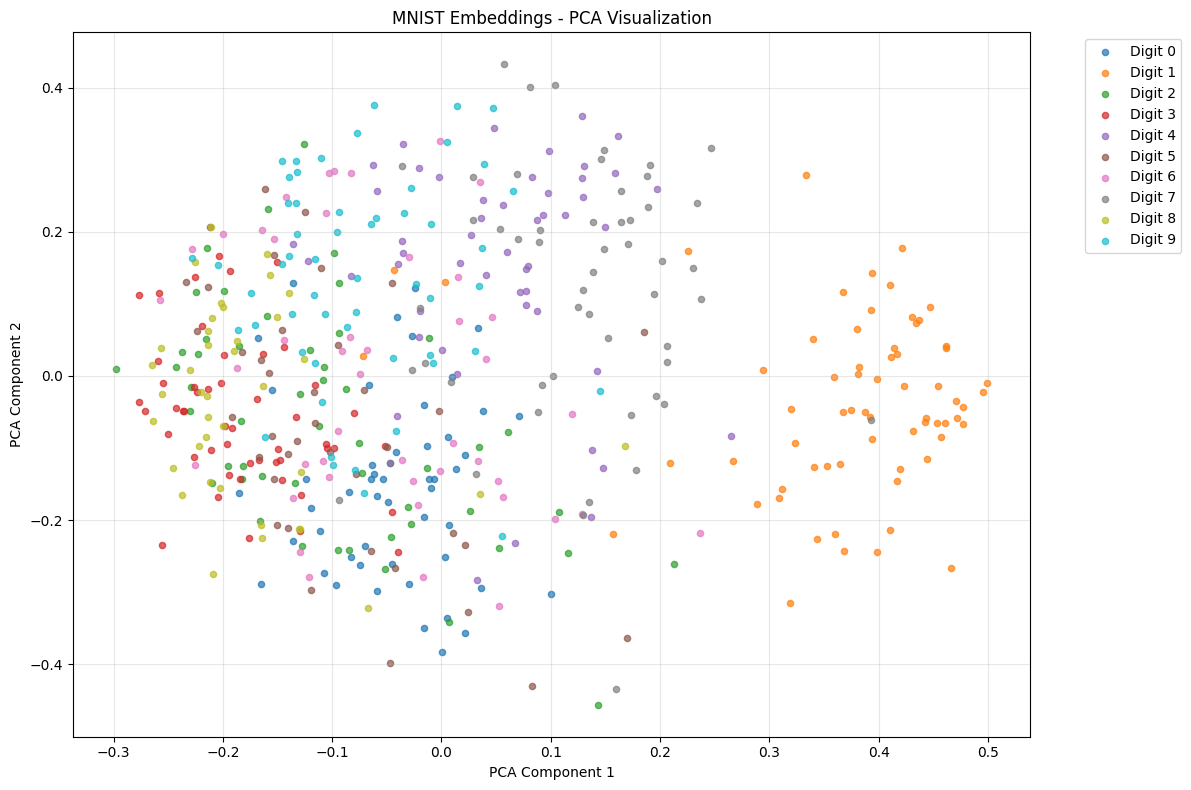

Creating t-SNE visualization...
Reducing dimensionality using TSNE...


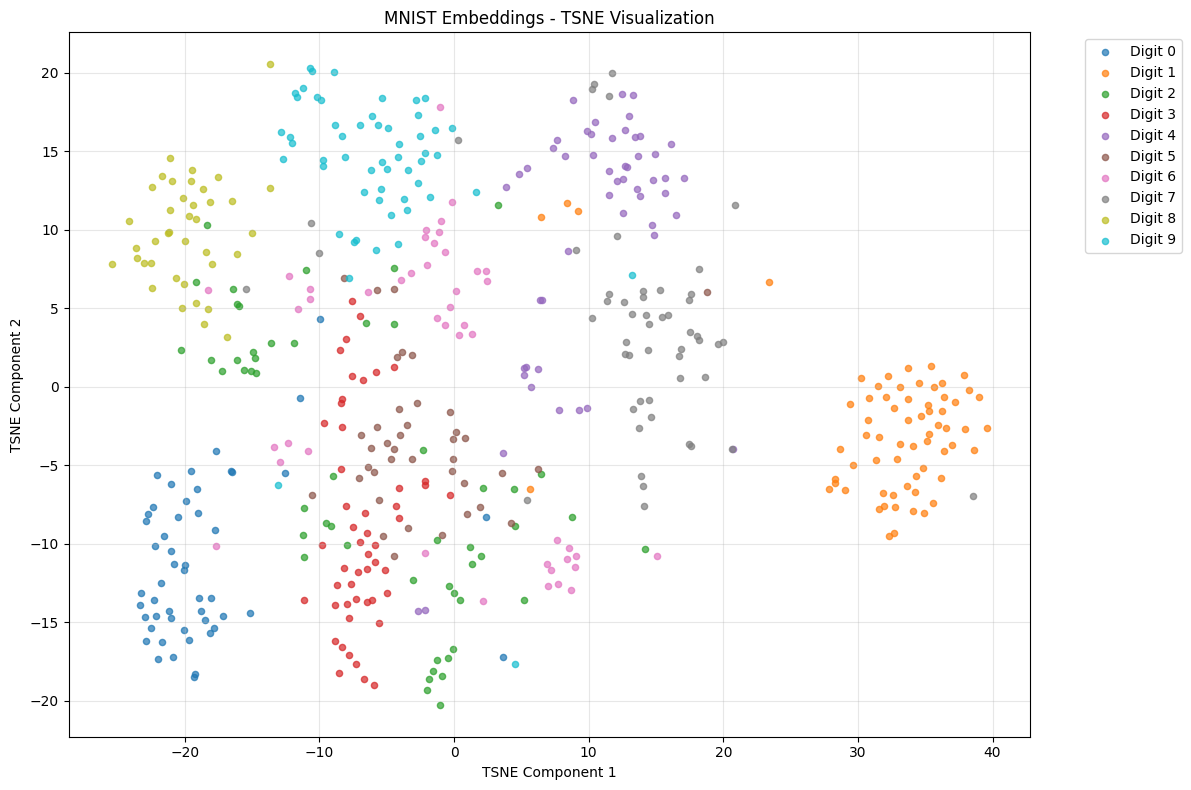

In [16]:
# Step 4: Visualize embeddings in 2D
print("\n4. Visualizing Embeddings in 2D Space:")
print("-" * 45)

# PCA visualization
print("Creating PCA visualization...")
pca_embeddings = visualize_embeddings_2d(embeddings, subset_labels, 
                                        method="pca", 
                                        title="MNIST Embeddings")

# t-SNE visualization
print("Creating t-SNE visualization...")
tsne_embeddings = visualize_embeddings_2d(embeddings, subset_labels, 
                                        method="tsne", 
                                        title="MNIST Embeddings")

---

### Compute the Similarity Matrix

In [17]:
def compute_similarity_matrix(embeddings: np.ndarray, labels: List[int], 
                            max_samples: int = 100) -> np.ndarray:
    """
    Compute and visualize similarity matrix for a subset of embeddings.
    
    Args:
        embeddings (np.ndarray): Array of embeddings.
        labels (List[int]): List of corresponding labels.
        max_samples (int, optional): Maximum number of samples to include in similarity matrix.
    
    Returns:
        np.ndarray: Similarity matrix.
    """
    # Take a subset for visualization
    if len(embeddings) > max_samples:
        indices = np.random.choice(len(embeddings), max_samples, replace=False)
        subset_embeddings = embeddings[indices]
        subset_labels = [labels[i] for i in indices]
    else:
        subset_embeddings = embeddings
        subset_labels = labels
    
    # Compute cosine similarity matrix
    similarity_matrix = np.dot(subset_embeddings, subset_embeddings.T)
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    
    # Sort by labels for better visualization
    sorted_indices = np.argsort(subset_labels)
    sorted_similarity = similarity_matrix[sorted_indices][:, sorted_indices]
    sorted_labels = [subset_labels[i] for i in sorted_indices]
    
    # Create heatmap
    sns.heatmap(sorted_similarity, 
                xticklabels=sorted_labels, 
                yticklabels=sorted_labels,
                cmap='coolwarm', 
                center=0,
                square=True,
                cbar_kws={'label': 'Cosine Similarity'})
    
    plt.title('Cosine Similarity Matrix of Image Embeddings\n(sorted by digit labels)')
    plt.xlabel('Image Index (by digit)')
    plt.ylabel('Image Index (by digit)')
    plt.tight_layout()
    plt.show()
    
    return similarity_matrix



5. Computing Similarity Matrix:
-----------------------------------


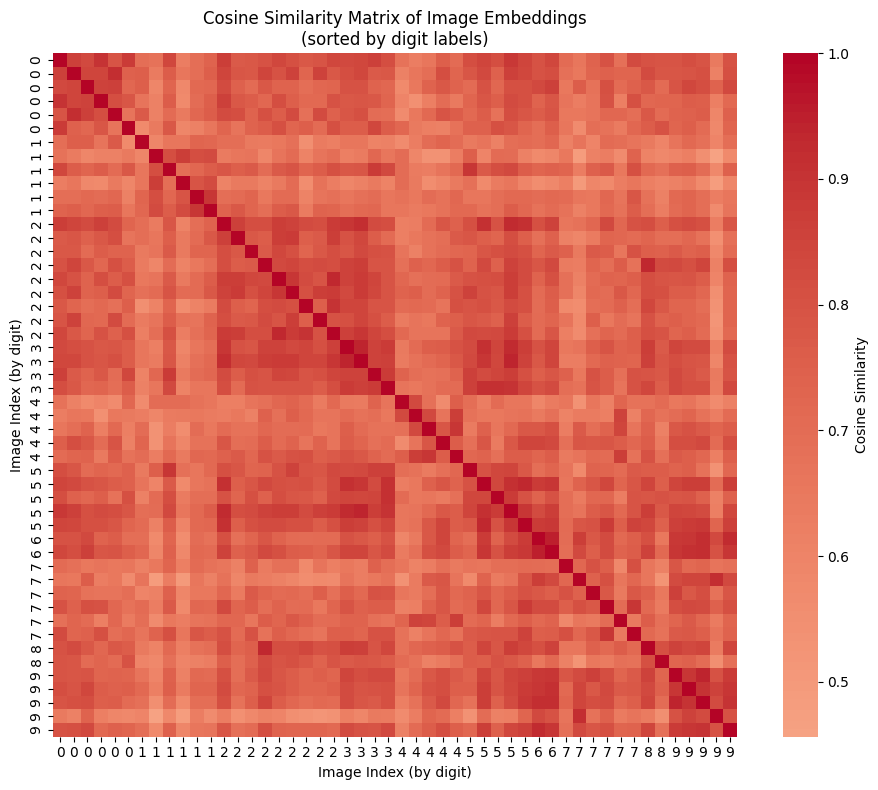

In [18]:
# Step 5: Compute similarity matrix
print("\n5. Computing Similarity Matrix:")
print("-" * 35)

similarity_matrix = compute_similarity_matrix(embeddings, subset_labels, 
                                            max_samples=50)

---

### Analyze the Embedding Quality


6. Embedding Quality Analysis:
-----------------------------------
Average intra-class similarity: 0.8137
Average inter-class similarity: 0.7347
Separation ratio: 1.1075


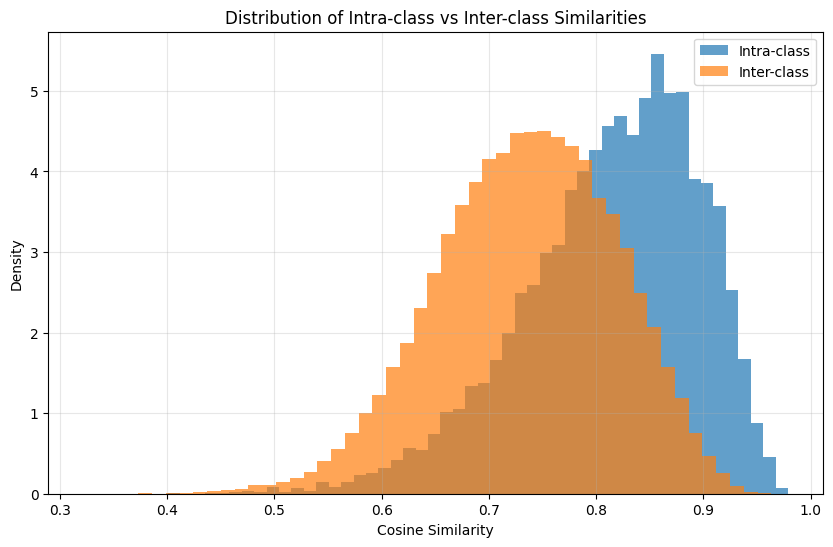

In [19]:
# Step 6: Analyze embedding quality
print("\n6. Embedding Quality Analysis:")
print("-" * 35)

# Compute average intra-class vs inter-class similarity
intra_similarities = []
inter_similarities = []

for i in range(len(subset_labels)):
    for j in range(i+1, len(subset_labels)):
        similarity = np.dot(embeddings[i], embeddings[j])
        
        if subset_labels[i] == subset_labels[j]:
            intra_similarities.append(similarity)
        else:
            inter_similarities.append(similarity)

print(f"Average intra-class similarity: {np.mean(intra_similarities):.4f}")
print(f"Average inter-class similarity: {np.mean(inter_similarities):.4f}")
print(f"Separation ratio: {np.mean(intra_similarities) / np.mean(inter_similarities):.4f}")

# Plot similarity distributions
plt.figure(figsize=(10, 6))
plt.hist(intra_similarities, bins=50, alpha=0.7, label='Intra-class', density=True)
plt.hist(inter_similarities, bins=50, alpha=0.7, label='Inter-class', density=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Distribution of Intra-class vs Inter-class Similarities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---